<a href="https://colab.research.google.com/github/dimsparagis0210/DFU-using-Deep-Learning/blob/main/DFU_using_Deep_Learning_Thesis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Πτυχιακή Εργασία

#### The goal of this BSc thesis is to develop a Deep Learning model for Object Detection. Specifically, the object of the model will be to detect ulcers in Diabetic Foots (DFU)

## Getting Dataset from Google drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Define dataset path (adjust if needed)
dataset_path = "/content/drive/MyDrive/DFU/Original Images"
trainset_path = "/content/drive/MyDrive/DFU/Patches"
testset_path = "/content/drive/MyDrive/DFU/TestSet"

# List categories (folders)
images = os.listdir(dataset_path)

In [3]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2

## Data Exploration

### Class Distribution

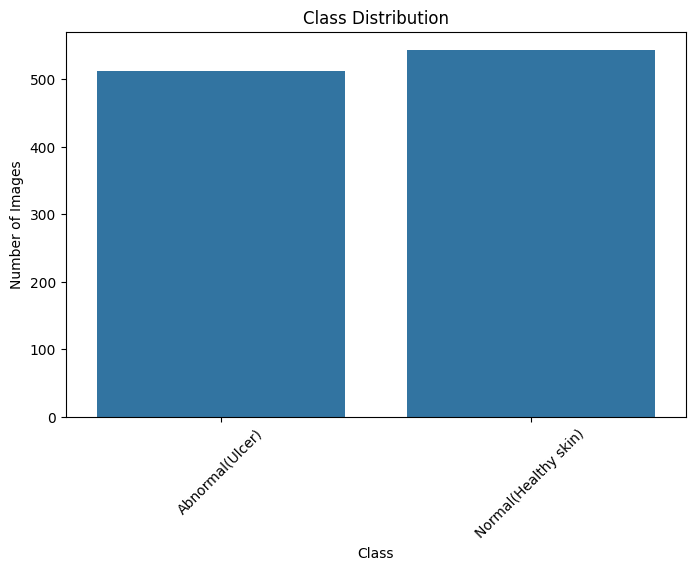

In [4]:
# Count images per class
class_counts = {category: len(os.listdir(os.path.join(trainset_path, category))) for category in os.listdir(trainset_path)}

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()


### Average Images

In [5]:
def compute_average_image(image_dir, img_size=(224, 224)):
    all_images = []
    for file_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, file_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(img_size)
                all_images.append(np.array(img, dtype=np.float32))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if all_images:
        mean_image = np.mean(all_images, axis=0).astype(np.uint8)
        return mean_image
    else:
        print(f"No images found in {image_dir}.")
        return None


In [6]:
# Compute average image for healthy skin patches
average_healthy = compute_average_image(trainset_path + "/Normal(Healthy skin)")

# Compute average image for ulcerated skin patches
average_ulcer = compute_average_image(trainset_path + "/Abnormal(Ulcer)")

#### Visualizing Averages of the Dataset and the Train Set

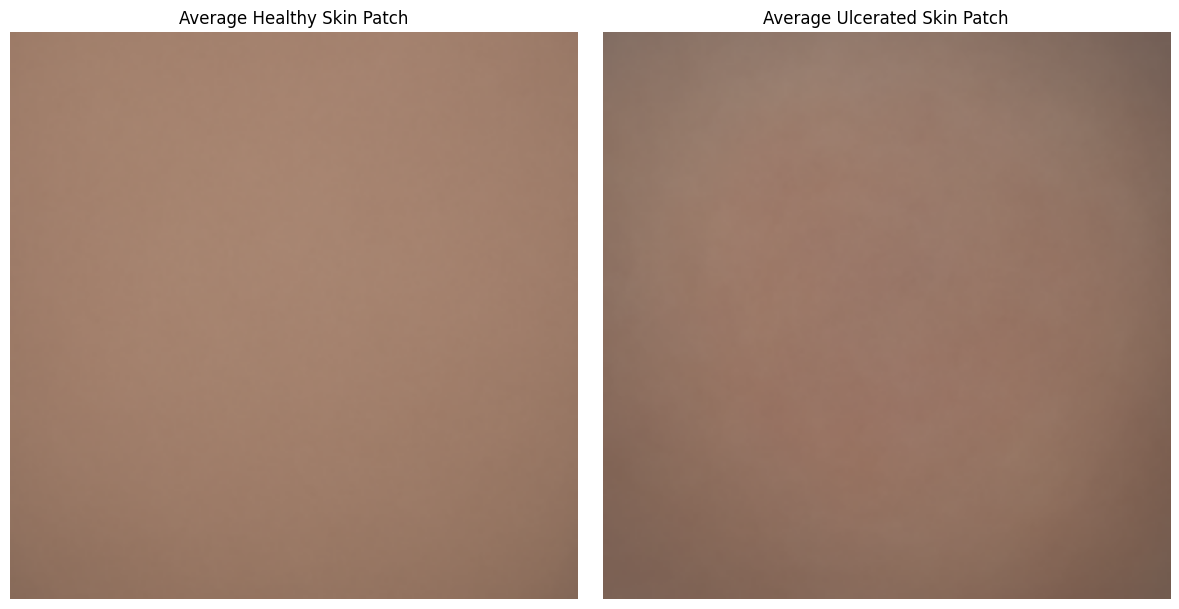

In [7]:
# Plotting the average images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

if average_healthy is not None:
    axes[0].imshow(average_healthy)
    axes[0].set_title("Average Healthy Skin Patch")
    axes[0].axis("off")
else:
    axes[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
    axes[0].set_title("Average Healthy Skin Patch")
    axes[0].axis("off")

if average_ulcer is not None:
    axes[1].imshow(average_ulcer)
    axes[1].set_title("Average Ulcerated Skin Patch")
    axes[1].axis("off")
else:
    axes[1].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
    axes[1].set_title("Average Ulcerated Skin Patch")
    axes[1].axis("off")

plt.tight_layout()
plt.show()



### Comparing sizes of the original dataset and the training set

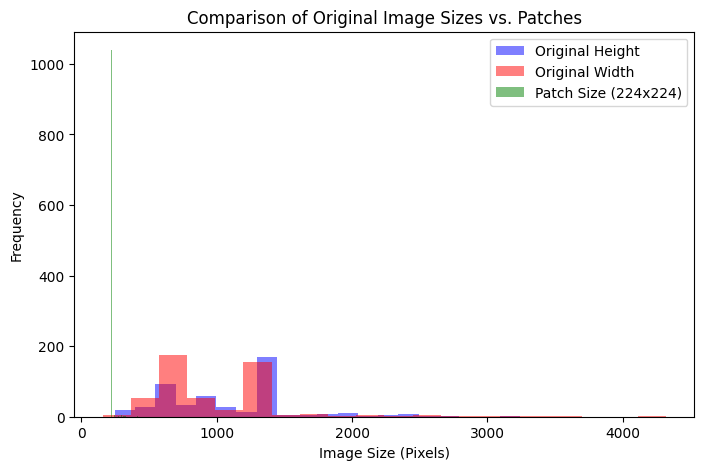

In [8]:
# Collect sizes
original_sizes = []
patch_sizes = []

for file in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, file))
    if img is not None:
        original_sizes.append(img.shape[:2])  # Height, Width

for category in ["Normal(Healthy skin)", "Abnormal(Ulcer)"]:
    category_path = os.path.join(trainset_path, category)
    for file in os.listdir(category_path):
        img = cv2.imread(os.path.join(category_path, file))
        if img is not None:
            patch_sizes.append(img.shape[:2])  # Height, Width

# Convert to NumPy arrays
original_sizes = np.array(original_sizes)
patch_sizes = np.array(patch_sizes)

# Plot size distributions
plt.figure(figsize=(8, 5))
plt.hist(original_sizes[:, 0], bins=20, alpha=0.5, label="Original Height", color="blue")
plt.hist(original_sizes[:, 1], bins=20, alpha=0.5, label="Original Width", color="red")
plt.hist(patch_sizes[:, 0], bins=20, alpha=0.5, label="Patch Size (224x224)", color="green")
plt.xlabel("Image Size (Pixels)")
plt.ylabel("Frequency")
plt.title("Comparison of Original Image Sizes vs. Patches")
plt.legend()
plt.show()


## Data Preprocessing

### Reading Dataset using Tensoflow

In [18]:
# Load dataset
batch_size = 32
img_size = (224, 224)  # Resize images to 224x224

train_dataset = tf.keras.utils.image_dataset_from_directory(
    trainset_path,
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    trainset_path,
    validation_split = 0.2,
    subset = "validation",
    shuffle=True,
    seed = 123,
    batch_size=batch_size,
    image_size=img_size
)

# Get class names
class_names = train_dataset.class_names

Found 1055 files belonging to 2 classes.
Using 844 files for training.
Found 1055 files belonging to 2 classes.
Using 211 files for validation.


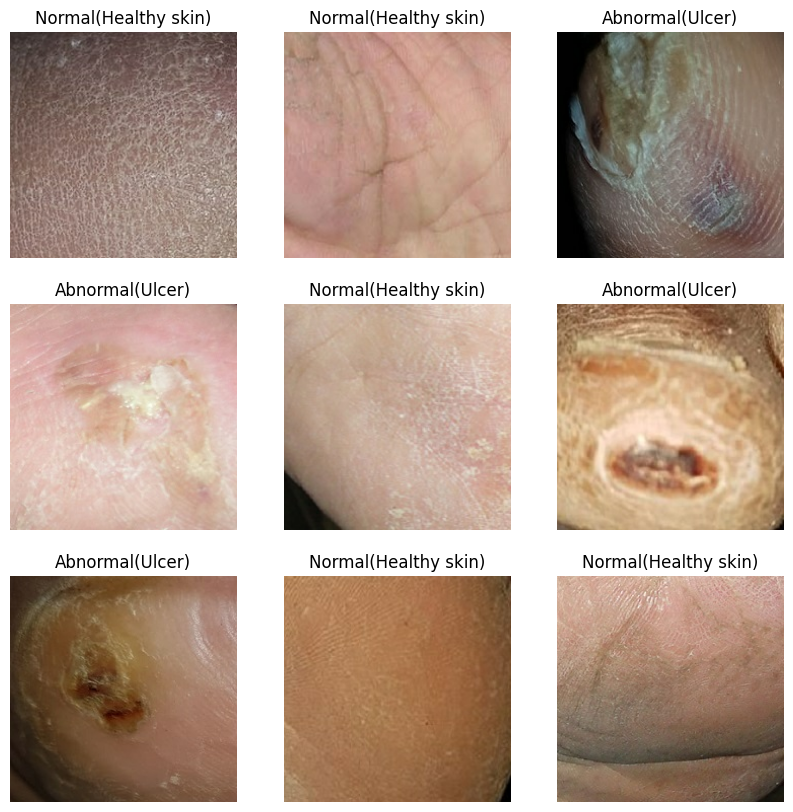

In [19]:
# Get a batch of images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Normalize Images Layer(Divide Pixel values with 255)

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Data Augmentation Layer

In [12]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    # Add other augmentation layers as needed
])

## Model development

### Custom Architecture

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# Convolution Layer 1
model.add(Conv2D(
    filters = 32, # feature detectors
    kernel_size = (3, 3), # feature detector size
    activation = 'relu',
    input_shape = (224, 224, 3)
))
model.add(MaxPooling2D(pool_size = (2,2)))

# Convolution Layer 2
model.add(Conv2D(
    filters = 64,
    kernel_size = (3,3),
    activation = 'relu'
))
model.add(MaxPooling2D(pool_size = (2,2)))

# Convolution Layer 3
model.add(Conv2D(
    filters = 128,
    kernel_size = (3,3),
    activation = 'relu'
))
model.add(MaxPooling2D(pool_size = (2,2)))

# Flatten and Fully Connected Layer
model.add(Flatten())
model.add(Dense(
    units = 128,
    activation = 'relu'
))
model.add(Dropout(0.5))
model.add(Dense(
    units = 1,
    activation = 'sigmoid'
))

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Utilizing pretrained models for comparison

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers to prevent them from being trained
base_model.trainable = False

# Build the model
resnet_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


## Model Training

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

### Training the custom CNN

In [25]:
custom_model_history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 50,
    callbacks = [earlyStopping]
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.5655 - loss: 89.3397 - val_accuracy: 0.8057 - val_loss: 0.4505
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.7926 - loss: 0.4886 - val_accuracy: 0.8626 - val_loss: 0.2853
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8600 - loss: 0.3451 - val_accuracy: 0.8341 - val_loss: 0.3446
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8332 - loss: 0.3856 - val_accuracy: 0.8246 - val_loss: 0.5400
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8106 - loss: 0.4742 - val_accuracy: 0.8199 - val_loss: 0.3228
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8305 - loss: 0.4056 - val_accuracy: 0.8815 - val_loss: 0.2728
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8651 - loss: 0.3221 - val_accuracy: 0.9289 - val_loss: 0.2494
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.8488 - loss: 0.3339 - val_accuracy: 0.8720 - 

### Training the pretrained model (ResNet50)

In [26]:
resnet_history = resnet_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 50,
    callbacks = [earlyStopping]
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 216s 8s/step - accuracy: 0.8490 - loss: 0.4841 - val_accuracy: 0.9810 - val_loss: 0.0841
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 0.9967 - loss: 0.0046 - val_accuracy: 0.9858 - val_loss: 0.0690
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 1.0000 - loss: 1.2535e-04 - val_accuracy: 0.9858 - val_loss: 0.0730
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - accuracy: 1.0000 - loss: 2.7542e-05 - val_accuracy: 0.9858 - val_loss: 0.0723
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 263s 8s/step - accuracy: 1.0000 - loss: 2.3660e-05 - val_accuracy: 0.9858 - val_loss: 0.0718
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 1.0000 - loss: 2.8184e-05 - val_accuracy: 0.9858 - val_loss: 0.0717
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 1.0000 - loss: 1.9414e-05 - val_accuracy: 0.9858 - val_loss: 0.0716
